## Working with 2 Dimensional Data: Example ADCP

In this example we show how to programatically download and work with 2 Dimensional OOI NetCDF data. We will use data from the ADCP Velocity Profiler (600kHz) deployed at the Coastal Endurance Oregon Inshore Surface Mooring. You will learn:

* how to find the data you are looking for
* how to use the machine to machine API to request data
* how to load the NetCDF data into your notebook, once the data request has completed
* how to explore and plot data

For this example, we are using data from the 600kHaz ADCP Velocity Profiler. You will need the Reference Designator, Stream and Data Delivery Method to make the request to the M2M API. More information about the instrument can be found here:
http://ooi.visualocean.net/instruments/view/CE01ISSM-MFD35-04-ADCPTM000

![CE01ISSM-MFD35-04-ADCPTM000](https://github.com/ooi-data-review/ooi_datateam_notebooks/raw/master/images/CE01ISSM-MFD35-04-ADCPTM000.png)

In [1]:
import requests
import time

Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner), or use the credentials provided below.


In [2]:
username = 'OOIAPI-D8S960UXPK4K03'
token = 'IXL48EQ2XY'

Specify your inputs.

In [3]:
subsite = 'CE01ISSM'
node = 'MFD35'
sensor = '04-ADCPTM000'
method = 'telemetered'
stream = 'adcp_velocity_earth'
beginDT = '2018-03-27T10:32:51.600Z'
endDT = '2018-04-26T10:32:51.600Z'

Request the data.

In [5]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(username, token))
data = r.json()

In [6]:
data['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/ooidatateam@gmail.com/20180522T202951-CE01ISSM-MFD35-04-ADCPTM000-telemetered-adcp_velocity_earth/catalog.html'

Check if the request has completed.

In [7]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 931 ms, sys: 67.8 ms, total: 999 ms
Wall time: 1min


In [8]:
import requests
import re
import xarray as xr
import pandas as pd
import os

Parse the thredds server to get a list of all NetCDF files.

In [9]:
url = data['allURLs'][0]
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/ooidatateam@gmail.com/20180522T202951-CE01ISSM-MFD35-04-ADCPTM000-telemetered-adcp_velocity_earth/deployment0009_CE01ISSM-MFD35-04-ADCPTM000-telemetered-adcp_velocity_earth_20180403T043300.648000-20180426T103251.600000.nc']

Load the list of NetCDF files into xarray. Note that this datasets has two dimensions, time and bin. Some variables are dimensioned along just time, others along both time and bin number.

In [10]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

<xarray.Dataset>
Dimensions:                         (bin: 30, time: 281)
Coordinates:
    obs                             (time) int32 dask.array<shape=(281,), chunksize=(100,)>
  * time                            (time) datetime64[ns] 2018-04-03T04:33:00.648000 ...
    pressure                        (time) float64 dask.array<shape=(281,), chunksize=(100,)>
    lat                             (time) float64 dask.array<shape=(281,), chunksize=(100,)>
    lon                             (time) float64 dask.array<shape=(281,), chunksize=(100,)>
Dimensions without coordinates: bin
Data variables:
    deployment                      (time) int32 dask.array<shape=(281,), chunksize=(100,)>
    id                              (time) |S64 dask.array<shape=(281,), chunksize=(100,)>
    bin_1_distance                  (time) float32 dask.array<shape=(281,), chunksize=(100,)>
    cell_length                     (time) float32 dask.array<shape=(281,), chunksize=(100,)>
    correlation_magnitude_b

Extract the bin depths, east, north and west values along the time dimensions. Note the .T for two dimensional variables.

In [11]:
time = ds['time'].data
bin_depths = ds['bin_depths'].data.T
east = ds['eastward_seawater_velocity'].data.T
north = ds['northward_seawater_velocity'].data.T
up = ds['upward_seawater_velocity'].data.T

Next we will plot the data.

In [12]:
import matplotlib.pyplot as plt
import numpy as np

To screen out surface noise velocities we will set the colorbar limit to the 90th percentile of the data.

In [13]:
lim_east = float("%2.2f" % np.nanpercentile(east, 90))
lim_north = float("%2.2f" % np.nanpercentile(north, 90))
lim_up = float("%2.2f" % np.nanpercentile(up, 90))
u_v_w = max([lim_east, lim_north, lim_up])

And plot.

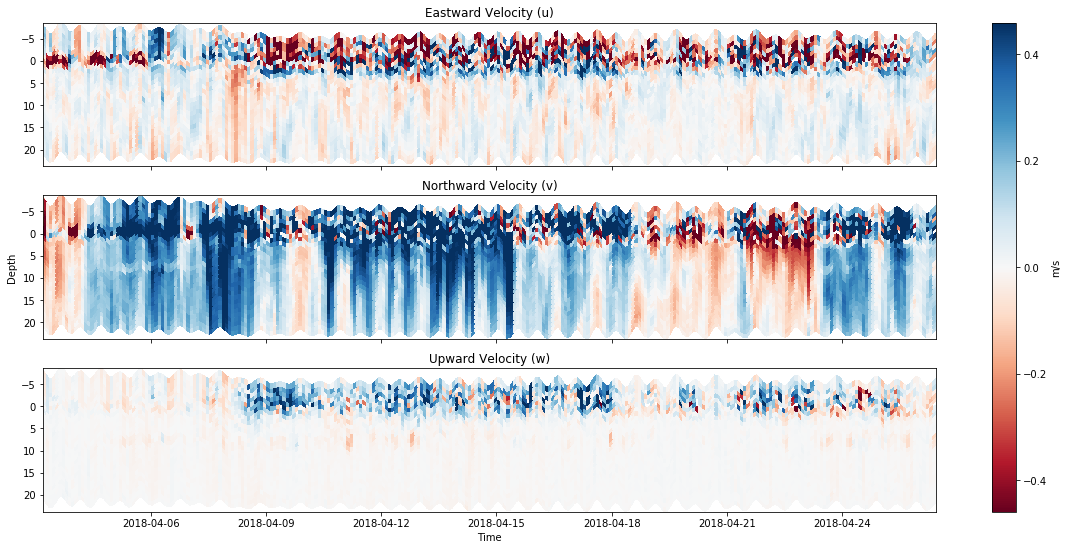

In [14]:
plt.close()
fig, axes = plt.subplots(3, sharex=True)
fig.set_size_inches(20, 9)

p0 = axes[0].pcolormesh(time, bin_depths, east, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
# axes[0].set_ylim(5,25)
axes[0].set_title('Eastward Velocity (u)')
axes[0].invert_yaxis()

p1 = axes[1].pcolormesh(time, bin_depths, north, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[1].set_title('Northward Velocity (v)')
# axes[1].set_ylim(5,25)
axes[1].invert_yaxis()
axes[1].set_ylabel('Depth')

p2 = axes[2].pcolormesh(time, bin_depths, up, cmap='RdBu',vmin=-u_v_w,vmax=u_v_w)
axes[2].set_title('Upward Velocity (w)')
# axes[2].set_ylim(5,25)
axes[2].invert_yaxis()
axes[2].set_xlabel('Time')

fig.colorbar(p0,ax=axes.ravel().tolist(), label='m/s')

plt.show()